<a href="https://colab.research.google.com/github/poojamahajan0712/TextSummarisation/blob/main/Text_Summarisation_Example2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Loading required packages
import numpy as np
import pandas as pd
import nltk
#nltk.download('punkt')  ## kind of tokeniser
import re
from nltk.tokenize import sent_tokenize
#nltk.download('stopwords')
from nltk.corpus import stopwords

https://www.analyticsvidhya.com/blog/2018/11/introduction-text-summarization-textrank-python/

In [ ]:
df=pd.read_csv("tennis_articles.csv",encoding='latin1')

In [ ]:
df.head()

,article_id,article_title,article_text,source
0,1,"I do not have friends in tennis, says Maria Sh...",Maria Sharapova has basically no friends as te...,https://www.tennisworldusa.org/tennis/news/Mar...
1,2,Federer defeats Medvedev to advance to 14th Sw...,"BASEL, Switzerland (AP)  Roger Federer advanc...",http://www.tennis.com/pro-game/2018/10/copil-s...
2,3,Tennis: Roger Federer ignored deadline set by ...,Roger Federer has revealed that organisers of ...,https://scroll.in/field/899938/tennis-roger-fe...
3,4,Nishikori to face off against Anderson in Vien...,Kei Nishikori will try to end his long losing ...,http://www.tennis.com/pro-game/2018/10/nishiko...
4,5,Roger Federer has made this huge change to ten...,"Federer, 37, first broke through on tour over ...",https://www.express.co.uk/sport/tennis/1036101...


In [ ]:
df['article_text'][0]

"Maria Sharapova has basically no friends as tennis players on the WTA Tour. The Russian player has no problems in openly speaking about it and in a recent interview she said: 'I don't really hide any feelings too much. I think everyone knows this is my job here. When I'm on the courts or when I'm on the court playing, I'm a competitor and I want to beat every single person whether they're in the locker room or across the net. So I'm not the one to strike up a conversation about the weather and know that in the next few minutes I have to go and try to win a tennis match. I'm a pretty competitive girl. I say my hellos, but I'm not sending any players flowers as well. Uhm, I'm not really friendly or close to many players. I have not a lot of friends away from the courts.' When she said she is not really close to a lot of players, is that something strategic that she is doing? Is it different on the men's tour than the women's tour? 'No, not at all. I think just because you're in the same

Splitting text into sentences 

In [ ]:

sentences=[]

for s in df['article_text']:
   sentences.append(sent_tokenize(s))

print(len(sentences))

8


In [ ]:
sentences[0]

['Maria Sharapova has basically no friends as tennis players on the WTA Tour.',
 "The Russian player has no problems in openly speaking about it and in a recent interview she said: 'I don't really hide any feelings too much.",
 'I think everyone knows this is my job here.',
 "When I'm on the courts or when I'm on the court playing, I'm a competitor and I want to beat every single person whether they're in the locker room or across the net.",
 "So I'm not the one to strike up a conversation about the weather and know that in the next few minutes I have to go and try to win a tennis match.",
 "I'm a pretty competitive girl.",
 "I say my hellos, but I'm not sending any players flowers as well.",
 "Uhm, I'm not really friendly or close to many players.",
 "I have not a lot of friends away from the courts.'",
 'When she said she is not really close to a lot of players, is that something strategic that she is doing?',
 "Is it different on the men's tour than the women's tour?",
 "'No, not at

In [ ]:
##flatten list

sentences=[y for x in sentences for y in x]

In [ ]:
print(len(sentences))

print(sentences[:3])

130
['Maria Sharapova has basically no friends as tennis players on the WTA Tour.', "The Russian player has no problems in openly speaking about it and in a recent interview she said: 'I don't really hide any feelings too much.", 'I think everyone knows this is my job here.']


Download GloVe Word Embeddings

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2021-02-09 10:01:09--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-02-09 10:01:09--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-02-09 10:01:09--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
# Extract word vectors 

word_embeddings={}
f = open('glove.6B.100d.txt',encoding='utf-8')  ## all word embedding have length of 100 
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    word_embeddings[word]=coefs
f.close()

In [ ]:
print(len(word_embeddings))
print(type(word_embeddings))
print(len(word_embeddings['life']))

# now we have 40,000 different terms in word_embeddings dictionary

400000
<class 'dict'>
100


Text preprocessing

In [ ]:
# remove punctuations, numbers and special characters

clean_sentences = pd.Series(sentences).str.replace("[^a-zA-Z]"," ")

# making alphabets lowercase
clean_sentences=[s.lower() for s  in clean_sentences]


In [ ]:
# removing stopwords
stop_words=stopwords.words('english')
def remove_stopwords(sen):
    sen_new = " ".join([i for i in sen if i not in stop_words])
    return sen_new

In [ ]:
clean_sentences=[remove_stopwords(r.split()) for r in clean_sentences]

In [ ]:
clean_sentences[:5]

['maria sharapova basically friends tennis players wta tour',
 'russian player problems openly speaking recent interview said really hide feelings much',
 'think everyone knows job',
 'courts court playing competitor want beat every single person whether locker room across net',
 'one strike conversation weather know next minutes go try win tennis match']

Vector representation of Sentences - We will first fetch vectors (each of size 100 elements) for the constituent words in a sentence and then take mean/average of those vectors to arrive at a consolidated vector for the sentence.

In [ ]:
sentence_vectors = []

for i in clean_sentences:
   if len(i) !=0:
      v = sum([word_embeddings.get(w,np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
   else:
      v = np.zeros((100,))
   sentence_vectors.append(v) 

Similarity Matrix Preparation

In [ ]:
# similarity matrix

sim_mat = np.zeros([len(sentences),len(sentences)])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

for i  in range(len(sentences)):
     for j in range(len(sentences)):
         if i !=j :
            sim_mat[i][j]= cosine_similarity(sentence_vectors[i].reshape(1,100),sentence_vectors[j].reshape(1,100))[0,0]


In [ ]:
sim_mat.shape

(130, 130)

Applying PageRank algorithm

In [ ]:
!pip install networkx
import networkx as nx

nx_graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(nx_graph)

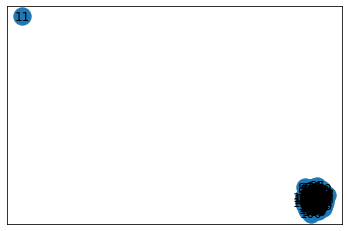

In [ ]:
nx.draw_networkx(nx_graph)

Summary Extraction

In [ ]:
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)

In [ ]:
# Extract top 10 sentences as the summary
for i in range(10):
  print(ranked_sentences[i][1])
  print('/n')

I was on a nice trajectorythen, Reid recalled.If I hadnt got sick, I think I could have started pushing towards the second week at the slams and then who knows. Duringa comeback attempt some five years later, Reid added Bernard Tomic and 2018 US Open Federer slayer John Millman to his list of career scalps.
/n
Major players feel that a big event in late November combined with one in January before the Australian Open will mean too much tennis and too little rest.
/n
So I'm not the one to strike up a conversation about the weather and know that in the next few minutes I have to go and try to win a tennis match.
/n
Speaking at the Swiss Indoors tournament where he will play in Sundays final against Romanian qualifier Marius Copil, the world number three said that given the impossibly short time frame to make a decision, he opted out of any commitment.
/n
Currently in ninth place, Nishikori with a win could move to within 125 points of the cut for the eight-man event in London next 